In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+100+1000, num_feat, grid, deg, e, seed=42)

In [3]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 3.6258033206091707
(0, 1)
(1, 6)
(6, 7)
(7, 12)
(12, 17)
(17, 18)
(18, 19)
(19, 24)


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1070.25it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1060.92it/s]


Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1013.49it/s]


In [6]:
# get training and test data set without costs
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train_cost.sols)

Obtaining constraints for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 725.77it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-0.5, num_epochs+0.5)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 20
log_step = 1

In [11]:
import copy
import time
from tqdm import tqdm
from earlystop import earlyStopper

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                # restore best model
                reg.load_state_dict(best_model_state)
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                   format(epoch, regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

### Large Learning Rate 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

(CVXPY) Dec 02 04:19:48 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 8


In [14]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  61.9579%, Val Regret:  66.5088%


Epoch    0, Loss:  -0.9978:   5%|██▊                                                    | 1/20 [00:13<03:46, 11.92s/it]

Epoch   1, Train Regret:   8.9719%, Val Regret:   8.8873%


Epoch    1, Loss:  -0.9988:  10%|█████▌                                                 | 2/20 [00:18<02:17,  7.66s/it]

Epoch   2, Train Regret:  10.3629%, Val Regret:   8.6697%


Epoch    2, Loss:  -0.9999:  15%|████████▎                                              | 3/20 [00:22<01:46,  6.26s/it]

Epoch   3, Train Regret:   9.5023%, Val Regret:  10.5612%


Epoch    3, Loss:  -0.9999:  20%|███████████                                            | 4/20 [00:27<01:29,  5.58s/it]

Epoch   4, Train Regret:  10.6412%, Val Regret:   9.5306%


Epoch    4, Loss:  -0.9999:  25%|█████████████▊                                         | 5/20 [00:31<01:35,  6.37s/it]


Epoch   5, Train Regret:   9.6631%, Val Regret:  10.3668%

Early Stop!

Evaluation:
Test Regret: 9.8296%
Training Elapsed Time: 17.53 Sec


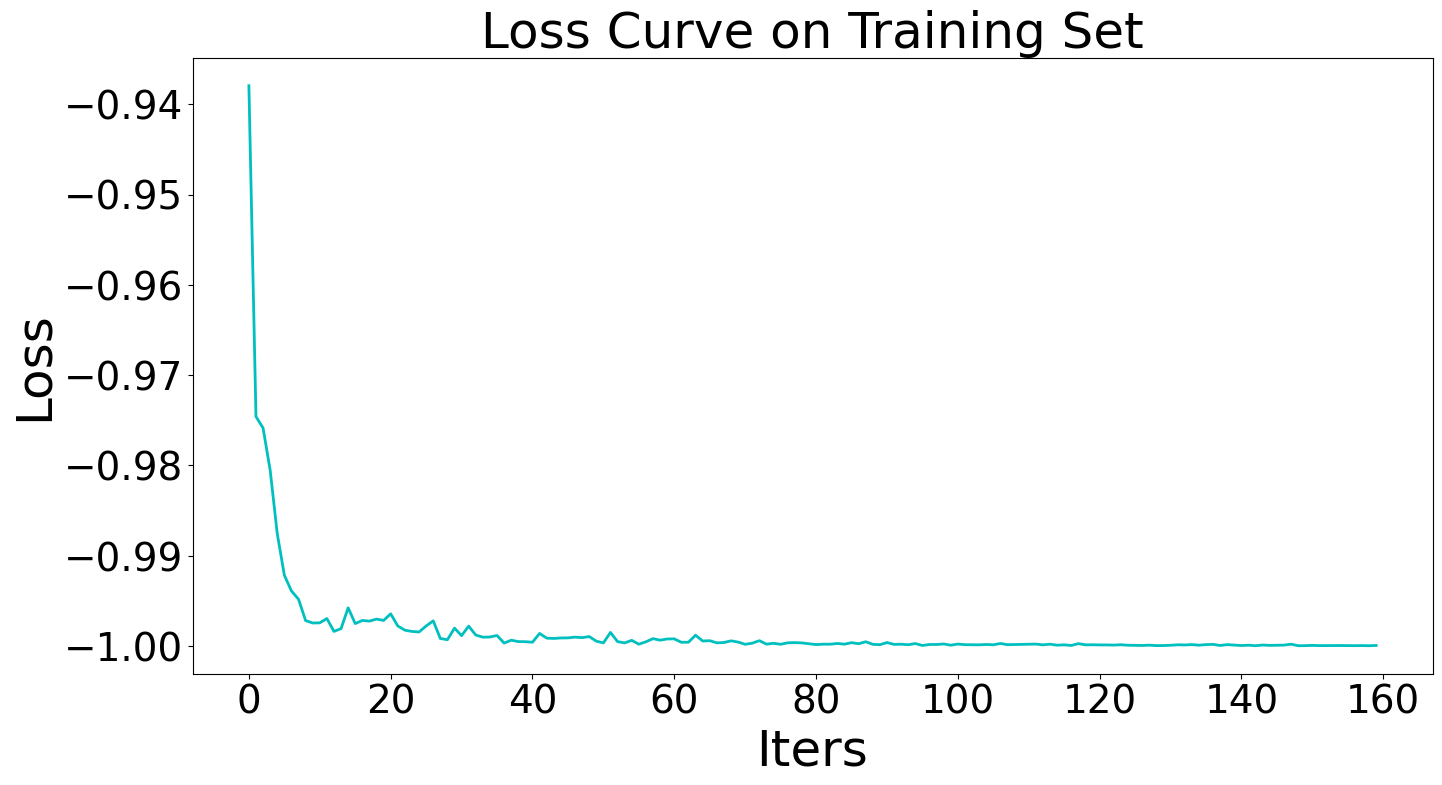

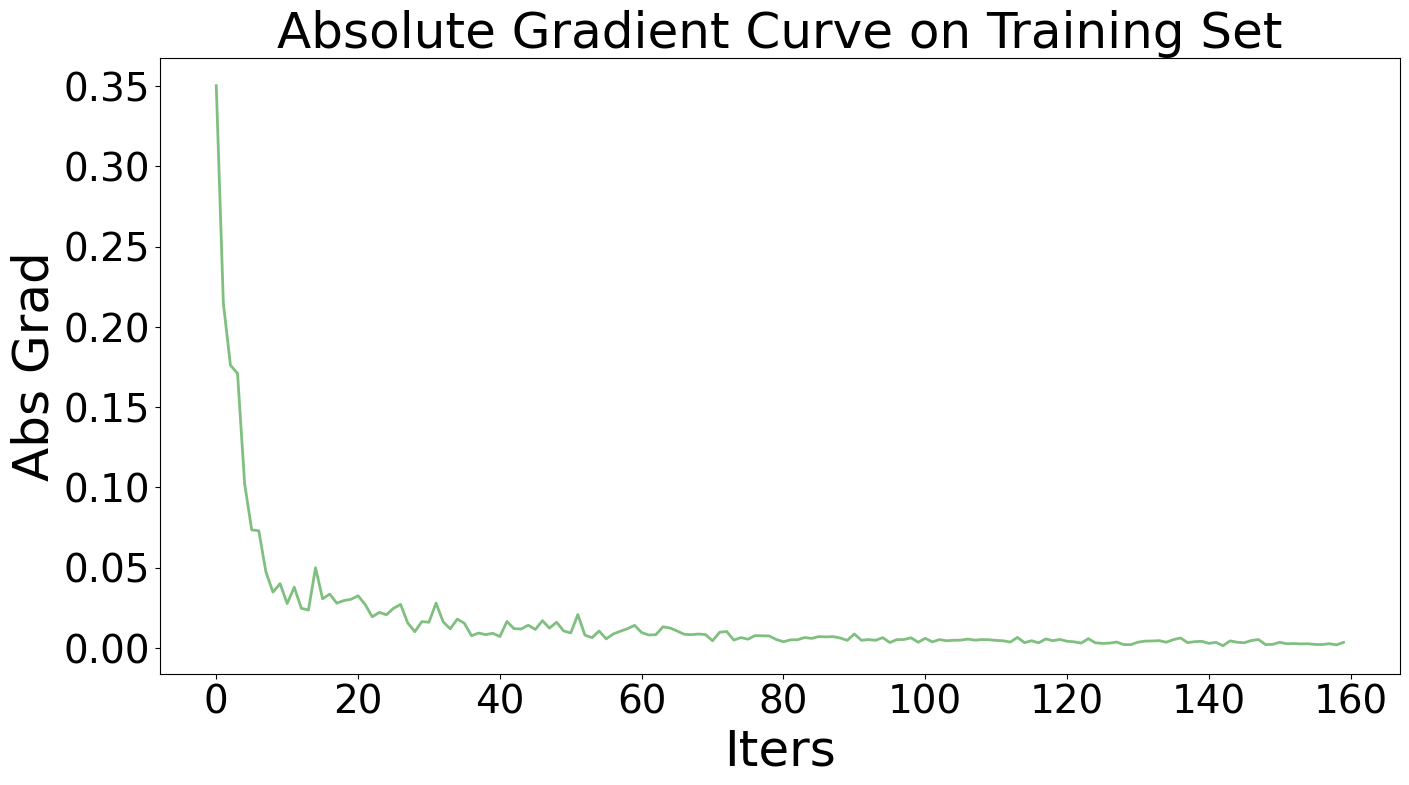

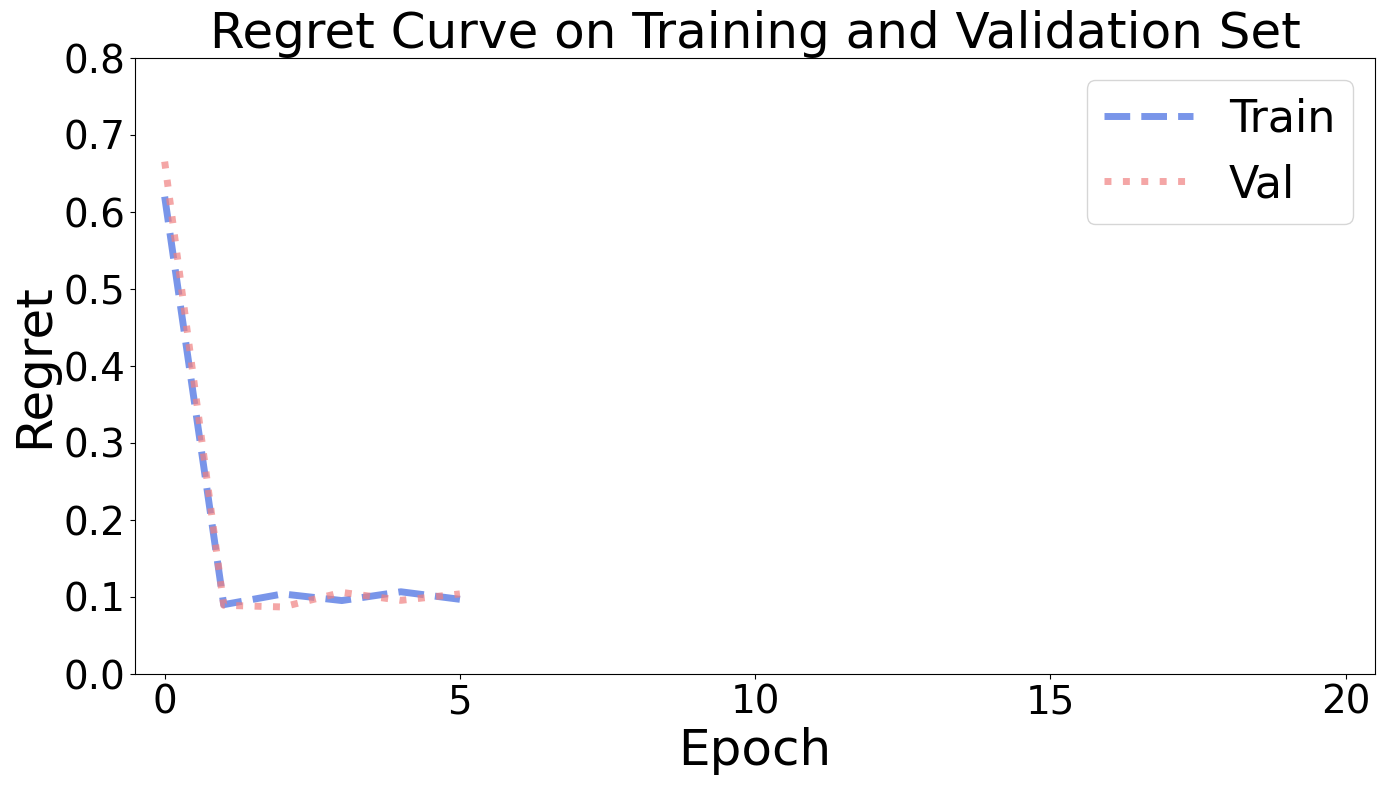

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

In [16]:
lr = 5e0
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  10.3629%, Val Regret:   8.6697%


Epoch    0, Loss:  -0.9978:   5%|██▊                                                    | 1/20 [00:05<01:24,  4.46s/it]

Epoch   1, Train Regret:  10.4249%, Val Regret:   9.2861%


Epoch    1, Loss:  -0.9969:  10%|█████▌                                                 | 2/20 [00:10<01:21,  4.52s/it]

Epoch   2, Train Regret:   9.6717%, Val Regret:   8.1928%


Epoch    2, Loss:  -0.9996:  15%|████████▎                                              | 3/20 [00:15<01:17,  4.56s/it]

Epoch   3, Train Regret:   8.7372%, Val Regret:   8.0517%


Epoch    3, Loss:  -0.9992:  20%|███████████                                            | 4/20 [00:19<01:12,  4.55s/it]

Epoch   4, Train Regret:   8.5149%, Val Regret:   8.4074%


Epoch    4, Loss:  -0.9993:  25%|█████████████▊                                         | 5/20 [00:24<01:07,  4.53s/it]

Epoch   5, Train Regret:   8.2634%, Val Regret:   8.7422%


Epoch    5, Loss:  -0.9999:  30%|████████████████▌                                      | 6/20 [00:28<01:07,  4.79s/it]


Epoch   6, Train Regret:   8.1750%, Val Regret:   8.1675%

Early Stop!

Evaluation:
Test Regret: 9.1384%
Training Elapsed Time: 12.21 Sec


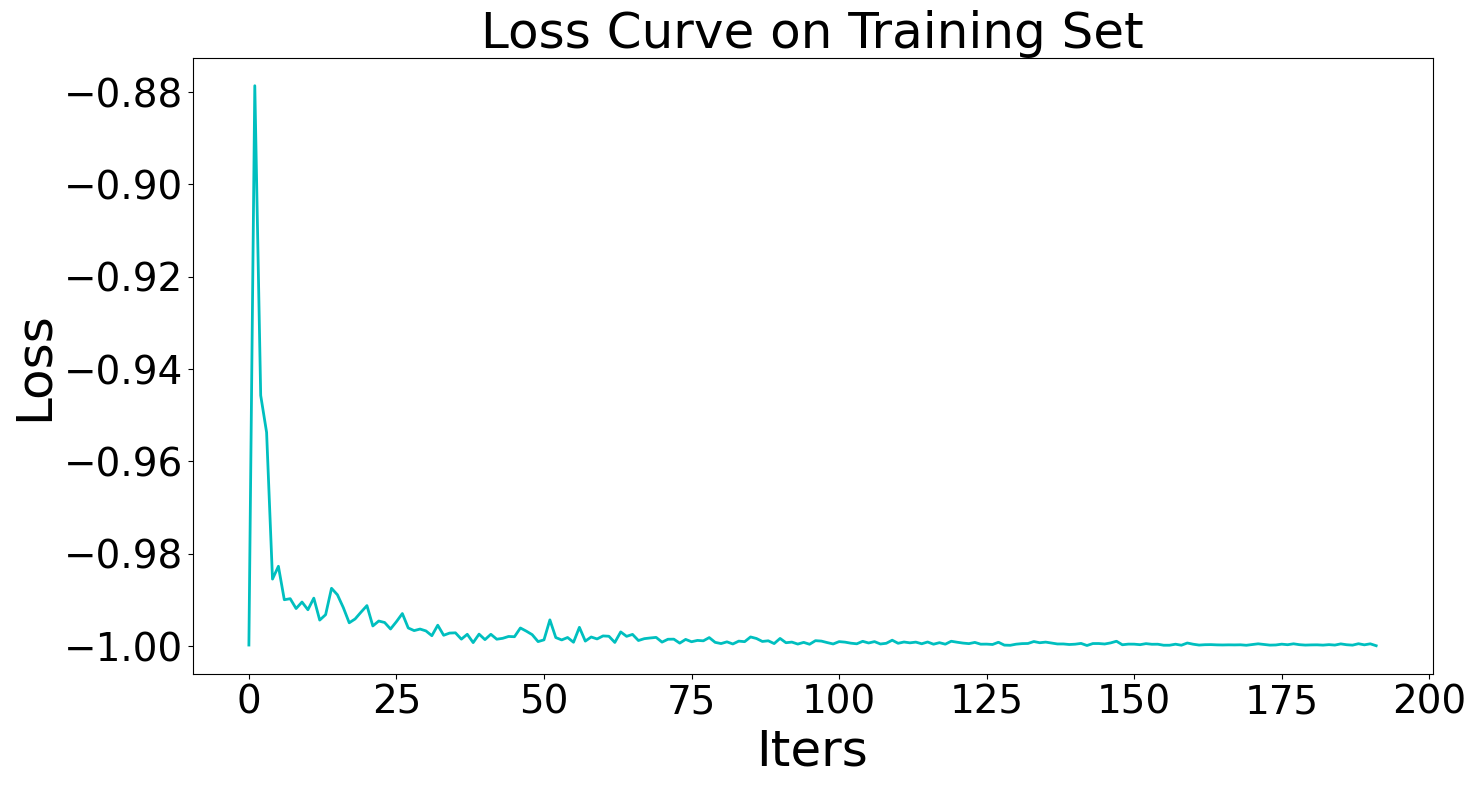

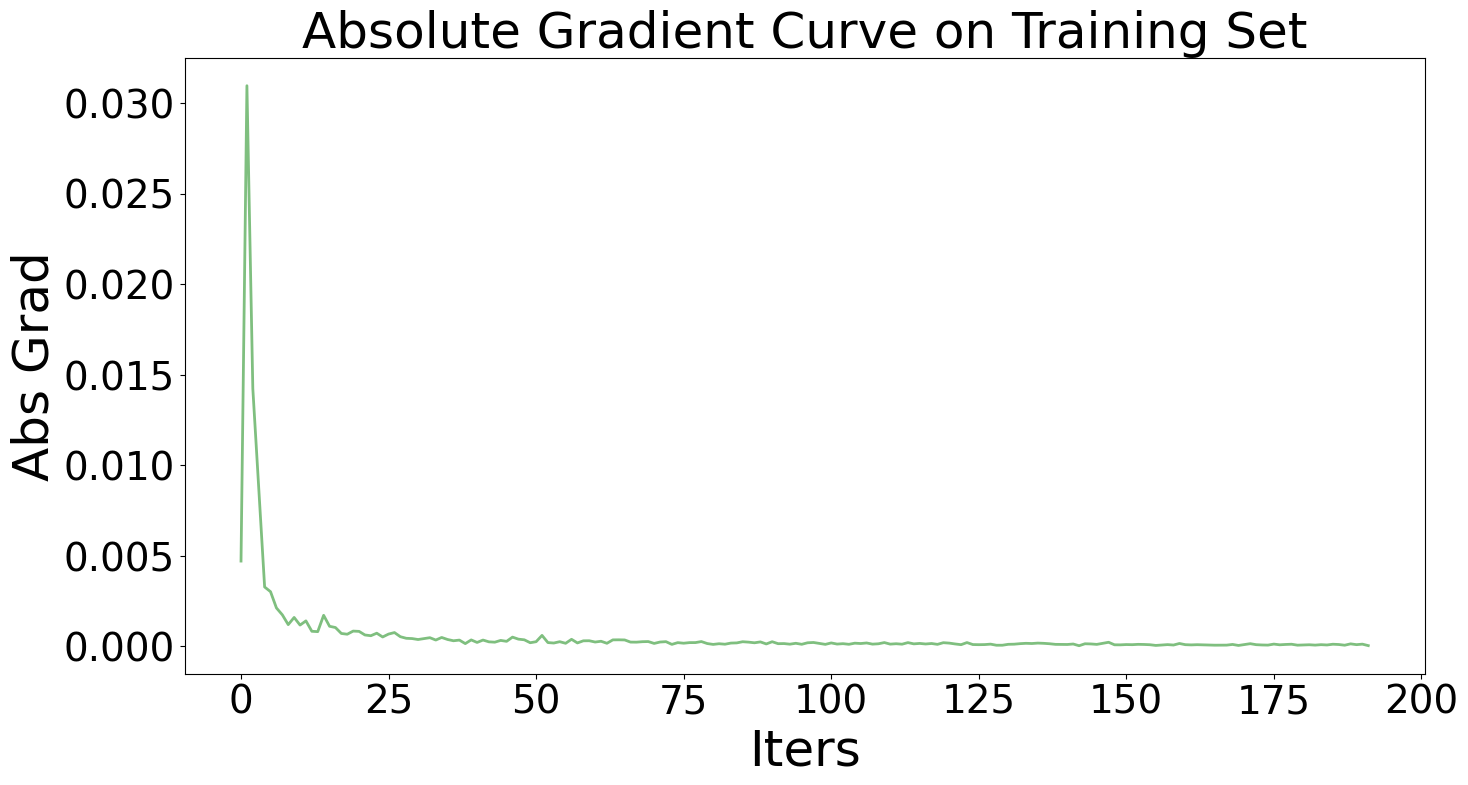

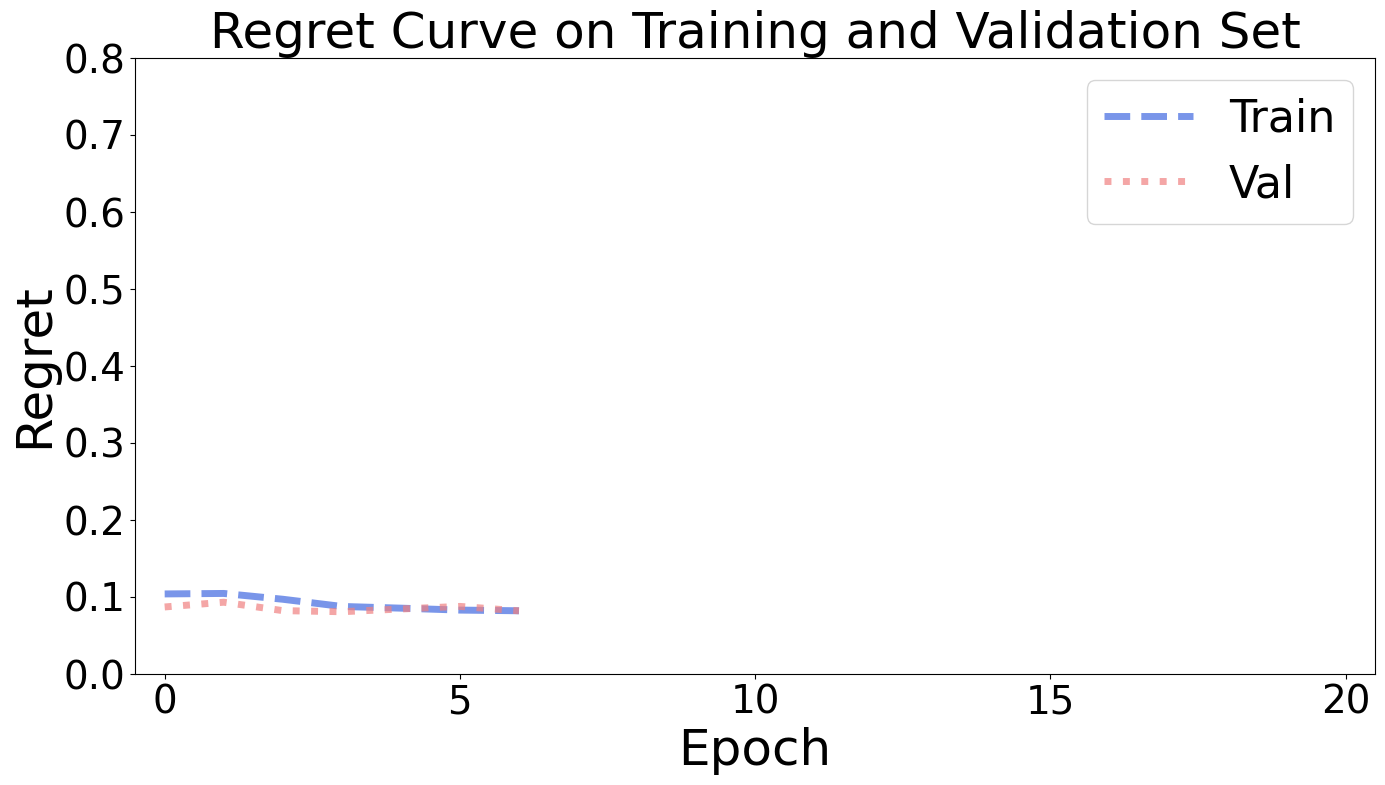

In [17]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Gradient Clip 

In [18]:
# init model
reg = LinearRegression()

In [19]:
def clip_gradients(model, threshold):
    for param in model.parameters():
        if param.grad is not None:
            with torch.no_grad():
                grad = param.grad
                grad[torch.abs(grad) < threshold] = 0

In [20]:
import copy
import time
from tqdm import tqdm
from earlystop import earlyStopper

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                # restore best model
                reg.load_state_dict(best_model_state)
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            clip_gradients(reg, threshold=1e-6) # clip
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                   format(epoch, regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

In [21]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  56.6962%, Val Regret:  51.7348%


Epoch    0, Loss:  -0.9984:   5%|██▊                                                    | 1/20 [00:06<01:27,  4.62s/it]

Epoch   1, Train Regret:  11.2289%, Val Regret:   9.5422%


Epoch    1, Loss:  -0.9991:  10%|█████▌                                                 | 2/20 [00:10<01:22,  4.57s/it]

Epoch   2, Train Regret:  10.2567%, Val Regret:   9.7142%


Epoch    2, Loss:  -0.9999:  15%|████████▎                                              | 3/20 [00:15<01:18,  4.60s/it]

Epoch   3, Train Regret:   9.6748%, Val Regret:  11.3161%


Epoch    3, Loss:  -0.9999:  20%|███████████                                            | 4/20 [00:20<01:20,  5.00s/it]


Epoch   4, Train Regret:  10.8124%, Val Regret:  12.5917%

Early Stop!

Evaluation:
Test Regret: 11.4674%
Training Elapsed Time: 8.27 Sec


In [22]:
lr = 5e0
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  11.2289%, Val Regret:   9.5422%


Epoch    0, Loss:  -0.9975:   5%|██▊                                                    | 1/20 [00:06<01:29,  4.70s/it]

Epoch   1, Train Regret:  10.9568%, Val Regret:  11.0670%


Epoch    1, Loss:  -0.9975:  10%|█████▌                                                 | 2/20 [00:10<01:22,  4.59s/it]

Epoch   2, Train Regret:   9.1730%, Val Regret:   8.3847%


Epoch    2, Loss:  -0.9994:  15%|████████▎                                              | 3/20 [00:15<01:18,  4.60s/it]

Epoch   3, Train Regret:   8.1914%, Val Regret:   9.7275%


Epoch    3, Loss:  -0.9990:  20%|███████████                                            | 4/20 [00:20<01:14,  4.64s/it]

Epoch   4, Train Regret:   8.5860%, Val Regret:   8.8032%


Epoch    4, Loss:  -0.9987:  25%|█████████████▊                                         | 5/20 [00:24<01:13,  4.93s/it]


Epoch   5, Train Regret:   8.7694%, Val Regret:   9.0671%

Early Stop!

Evaluation:
Test Regret: 8.1247%
Training Elapsed Time: 10.44 Sec
